# R-CNN

Rich feature hierarchies for accurate object detection and semantic segmentation

<div>
    <img src="https://unerue.synology.me/course/computer-vision/rcnn1.png" style="height: 240px;" />
</div>

## Selective Search

색상, 질감, 영역크기 등을 이용해 non-objective segmentation을 수행한다. 이 작업을 통해 좌측 제일 하단 그림과 같이 많은 small segmented areas들을 얻을 수 있다. Bottom-up 방식으로 small segemented areas들을 합쳐서 더 큰 segemented areas들을 만든다. (2)의 작업을 반복하여 최종적으로 2000개의 region proposal을 생성한다. 2000장의 region proposals를 얻게 되면 warp를 통해 이미지를 227x227로 사이즈를 통합시켜준다.(CNN arichitecture는 고정된 227x227 pixel size의 입력을 요구한다.)

$$S_{\text{color}}(r_i,r_j)=\sum_{k=1}^{n}\min{(c_i^k,c_j^k)}$$

$$C_t=\frac{\text{size}(r_i)\times C_i+\text{size}(r_j)\times C_j}{\text{size}(r_i)+\text{size}(r_j)}$$

$$S_{\text{texture}}(r_i,r_j)=\sum_{k=1}^{n}\min{(c_i^k,c_j^k)}$$

$$S_{\text{size}}(r_i,r_j)=1-\frac{\text{size}(r_i)+\text{size}(r_j)}{\text{size}(\text{image})}$$

$$\text{fill}(r_i,r_j)=1-\frac{\text{size}(\text{BB}_{ij})-\text{size}(r_i)-\text{size}(r_i)}{\text{size}(\text{image})}$$

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage import io, data, color, transform, feature, segmentation, util


def _generate_segments(image, scale, sigma, min_size):
    """Segment smallest regions by the algorithm of Felzenswalb and Huttenlocher
    
    Args:
        image: an original image
    """
    # open the Image
    mask = segmentation.felzenszwalb(
        util.img_as_float(image), scale=scale, sigma=sigma, min_size=min_size
    )

    # merge mask channel to the image as a 4th channel
    image = np.append(image, np.zeros(image.shape[:2])[:, :, np.newaxis], axis=2)
    image[:, :, 3] = mask

    return image


def _similarity_color(r1, r2):
    """Calculate the sum of histogram intersection of colour"""
    return sum([min(a, b) for a, b in zip(r1["hist_c"], r2["hist_c"])])


def _similarity_texture(r1, r2):
    """Calculate the sum of histogram intersection of texture"""
    return sum([min(a, b) for a, b in zip(r1["hist_t"], r2["hist_t"])])


def _similarity_size(r1, r2, imsize):
    """Calculate the size similarity over the image"""
    return 1.0 - (r1["size"] + r2["size"]) / imsize


def _similarity_fill(r1, r2, imsize):
    """Calculate the fill similarity over the image"""
    bbsize = (
        (max(r1["max_x"], r2["max_x"]) - min(r1["min_x"], r2["min_x"]))
        * (max(r1["max_y"], r2["max_y"]) - min(r1["min_y"], r2["min_y"]))
    )
    return 1.0 - (bbsize - r1["size"] - r2["size"]) / imsize


def _calc_similarity(r1, r2, imsize):
    return (
        _similarity_color(r1, r2) + _similarity_texture(r1, r2)
        + _similarity_size(r1, r2, imsize) + _similarity_fill(r1, r2, imsize)
    )


def _calc_colour_hist(image, num_channels=3, bins=25):
    """Calculate colour histogram for each region the size of output 
    histogram will be BINS * COLOUR_CHANNELS(3) number of bins is 25 
    as same as [uijlings_ijcv2013_draft.pdf] extract HSV
    """
    hist = np.array([])
    for channel in range(num_channels):
        # extracting one colour channel
        c = image[:, channel]
        # calculate histogram for each colour and join to the result
        hist = np.concatenate(
            [hist] + [np.histogram(c, bins, (0.0, 255.0))[0]]
        )
    # L1 normalize
    hist = hist / len(image)

    return hist


def _calc_texture_gradient(image):
    """
        calculate texture gradient for entire image
        The original SelectiveSearch algorithm proposed Gaussian derivative
        for 8 orientations, but we use LBP instead.
        output will be [height(*)][width(*)]
    """
    ret = np.zeros((image.shape[0], image.shape[1], image.shape[2]))
    for channel in (0, 1, 2):
        ret[:, :, channel] = feature.local_binary_pattern(
            img[:, :, channel], P=8, R=1.0
        )

    return ret


def _calc_texture_hist(image, num_channels=3, bins=10):
    """
        calculate texture histogram for each region
        calculate the histogram of gradient for each colours
        the size of output histogram will be
            BINS * ORIENTATIONS * COLOUR_CHANNELS(3)
    """
    hist = np.array([])
    for channel in range(num_channels):
        # mask by the color channel
        fd = image[:, channel]
        # calculate histogram for each orientation and concatenate them all
        # and join to the result
        hist = np.concatenate(
            [hist] + [np.histogram(fd, bins, (0.0, 1.0))[0]]
        )
    # L1 Normalize
    hist = hist / len(image)

    return hist


def _extract_regions(img):
    regions = {}
    # get hsv image
    hsv = color.rgb2hsv(img[:, :, :3])
    # pass 1: count pixel positions
    for y, i in enumerate(img):
        for x, (r, g, b, l) in enumerate(i):
            # initialize a new region
            if l not in regions:
                regions[l] = {
                    "min_x": 0xffff, "min_y": 0xffff,
                    "max_x": 0, "max_y": 0, "labels": [l]
                }
            # bounding box
            if regions[l]["min_x"] > x:
                regions[l]["min_x"] = x
            elif regions[l]["min_y"] > y:
                regions[l]["min_y"] = y
            elif regions[l]["max_x"] < x:
                regions[l]["max_x"] = x
            elif regions[l]["max_y"] < y:
                regions[l]["max_y"] = y

    # pass 2: calculate texture gradient
    tex_grad = _calc_texture_gradient(img)
    # pass 3: calculate colour histogram of each region
    for k, v in list(regions.items()):
        # colour histogram
        masked_pixels = hsv[:, :, :][img[:, :, 3] == k]
        regions[k]["size"] = len(masked_pixels / 4)
        regions[k]["hist_c"] = _calc_colour_hist(masked_pixels)
        # texture histogram
        regions[k]["hist_t"] = _calc_texture_hist(tex_grad[:, :][img[:, :, 3] == k])

    return regions


def _extract_neighbours(regions):
    def intersect(a, b):
        if (a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]):
            return True
        return False

    R = list(regions.items())
    neighbours = []
    for cur, a in enumerate(R[:-1]):
        for b in R[cur + 1:]:
            if intersect(a[1], b[1]):
                neighbours.append((a, b))

    return neighbours


def _merge_regions(r1, r2):
    new_size = r1["size"] + r2["size"]
    rt = {
        "min_x": min(r1["min_x"], r2["min_x"]),
        "min_y": min(r1["min_y"], r2["min_y"]),
        "max_x": max(r1["max_x"], r2["max_x"]),
        "max_y": max(r1["max_y"], r2["max_y"]),
        "size": new_size,
        "hist_c": (
            r1["hist_c"] * r1["size"] + r2["hist_c"] * r2["size"]) / new_size,
        "hist_t": (
            r1["hist_t"] * r1["size"] + r2["hist_t"] * r2["size"]) / new_size,
        "labels": r1["labels"] + r2["labels"]
    }
    return rt


class SelectiveSearch:
    """Selective Search

    Args:
        im_orig : ndarray
            Input image
        scale : int
            Free parameter. Higher means larger clusters in felzenszwalb segmentation.
        sigma : float
            Width of Gaussian kernel for felzenszwalb segmentation.
        min_size : int
            Minimum component size for felzenszwalb segmentation.

    Returns:
        img : ndarray
            image with region label
            region label is stored in the 4th value of each pixel [r,g,b,(region)]
        regions : array of dict
            [
                {
                    'rect': (left, top, width, height),
                    'labels': [...],
                    'size': component_size
                },
                ...
            ]
    
    """
    def __init__(self, scale=1.0, sigma=0.8, min_size=50):
        self.scale = scale
        self.sigma = sigma
        self.min_size = min_size
        
    def __call__(self, image):
        assert image.shape[2] == 3, 'An image is expected to be 3 channels'
        image = _generate_segments(image, self.scale, self.sigma, self.min_size)
        image_size = image.shape[0] * image.shape[1]
        regions = _extract_regions(image)
        # extract neighbouring information
        neighbours = _extract_neighbours(regions)
        # calculate initial similarities
        similarities = {}
        for (ai, ar), (bi, br) in neighbours:
            similarities[(ai, bi)] = _calc_similarity(ar, br, image_size)

        # hierarchal search
        while similarities != {}:
            # get highest similarity
            i, j = sorted(similarities.items(), key=lambda i: i[1])[-1][0]
            # merge corresponding regions
            t = max(regions.keys()) + 1.0
            regions[t] = _merge_regions(regions[i], regions[j])
            # mark similarities for regions to be removed
            key_to_delete = []
            for k, v in list(similarities.items()):
                if (i in k) or (j in k):
                    key_to_delete.append(k)
            # remove old similarities of related regions
            for k in key_to_delete:
                del similarities[k]
            # calculate similarity set with the new region
            for k in [a for a in key_to_delete if a != (i, j)]:
                n = k[1] if k[0] in (i, j) else k[0]
                similarities[(t, n)] = _calc_similarity(regions[t], regions[n], image_size)

        boxes = []
        for k, r in list(regions.items()):
            boxes.append({
                'boxes': (
                    r['min_x'], r['min_y'], 
                    r['max_x'] - r['min_x'], r['max_y'] - r['min_y']),
#                     r['min_x'], r['min_y'], r['max_x'], r['max_y']
                'size': r['size'],
                'labels': r['labels']
            })
            
        candidates = set()
        for r in boxes:
            # excluding same rectangle (with different segments)
            if r['boxes'] in candidates:
                continue
            # excluding regions smaller than 2000 pixels
            if r['size'] < 1000:
                continue
            # distorted rects
            x, y, w, h = r['boxes']
            if w / h > 1.2 or h / w > 1.2:
                continue
            candidates.add(r['boxes'])

#         return image, boxes
        return image, candidates

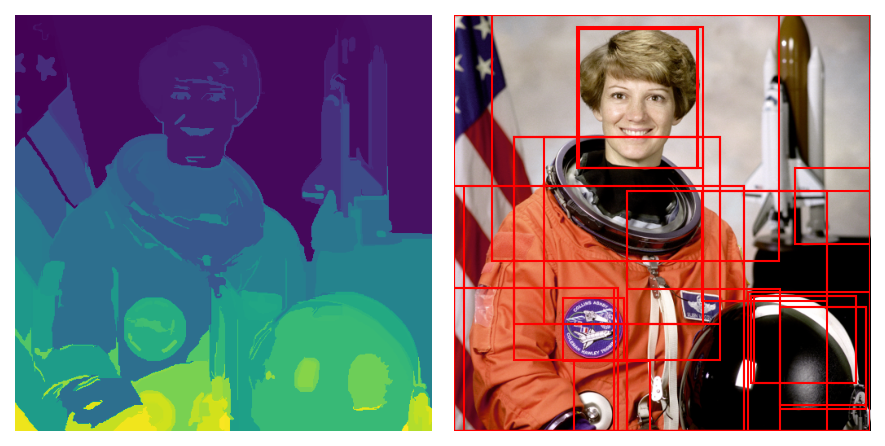

In [21]:
img = data.astronaut()

# perform selective search
selective_search = SelectiveSearch(scale=500.0, sigma=0.8, min_size=50)
img_lbl, regions = selective_search(img)

# candidates = set()
# for r in regions:
#     # excluding same rectangle (with different segments)
#     if r['boxes'] in candidates:
#         continue
#     # excluding regions smaller than 2000 pixels
#     if r['size'] < 1000:
#         continue
#     # distorted rects
#     x, y, w, h = r['boxes']
#     if w / h > 1.2 or h / w > 1.2:
#         continue
#     candidates.add(r['boxes'])
    

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6, 6), dpi=150)
axes[1].imshow(img)
axes[0].imshow(img_lbl[:, :, 3])
for x, y, w, h in regions:
    rect = Rectangle(
        (x, y), w, h, fill=False, edgecolor='red', linewidth=1)
    axes[1].add_patch(rect)

axes[1].axis('off')
axes[0].axis('off')
fig.tight_layout()
plt.show()

In [125]:
from torchvision import transforms
from torchvision import models
from torch import nn, Tensor

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

2000장의 region proposals와 ground-truth box의 IoU(Intersection of Union)을 비교하여 IoU가 0.5보다 큰 경우 positive samples, 0.5보다 작은 경우 negative samples로 나눈다. 이렇게 sample을 나눴을 때, ground truth만 positive sample로 정의할때 보다 30배 많은 학습데이터를 얻을 수 있다. 많은 데이터를 통해 overfitting을 방지한다. Positive sample는 객체가 포함되어 있는 sample을 의미하고, negative sample은 객체가 포함되지 않은 배경 sample을 의미한다. 이렇게 나눈 후 positive sample 32개 + negative sample 96개 = 128개의 이미지로 이루어진 하나의 미니 배치를 만든다.
이렇게 생성된 배치들을 이용해 fine-tuning을 진행한다. fine-tuning을 하기 위해서 기존의 pre-trained된 AlexNet의 마지막 softmax layer를 수정해서 N+1 way classification을 수행하게 한다. 이때, N은 R-CNN에서 사용하는 dataset의 객체들의 종류의 개수이고, 1을 더해준 이유는 배경인지 판단하기 위해서이다. SGD를 통해 N+1 way classification을 수행하면서 학습된 CNN 구조는 domain-specific fine-tuning을 이룬다.
마지막의 N+1 way classification을 위해 수정한 softmax layer는 R-CNN 모델 사용시 사용하지 않는다. 왜냐하면 softmax layer는 fine-tuning을 위해 사용한 것이고, 원래 R-CNN에서 CNN 구조의 목표는 4096-dimensional feature vector를 추출하는 것이기 때문이다.

## Intersection of union

Intersection of union(IoU)는 교집합 영역 넓이 / 합집합 영역 넓이


## Linear support vector machines

Linear support vector machines(SVMs)은 2000장의 region proposals에서 fine-tuning때와는 다르게 ground truth box만을 positive sample, IoU 값이 0.3보다 작은 것은 negative sample로 지정한다. 이때, IoU값이 0.3보다 큰 경우 무시한다. 이때 0.3은 gird search를 통해 찾은 값이다. 이후는 fine-tuning과 마찬가지로 positive sample 32개 + negative sample 96개 = 128개의 미니배치를 구성한 후 fine-tuning된 AlexNet에 입력하여 4096 dimensional feature vector를 추출한다. 추출된 벡터를 이용해 linear SVMs를 학습한다. SVM은 2진 분류를 수행하므로 분류하려는 객체의 종류만큼 SVM이 필요하다. 학습이 한 차례 끝난 후, hard negative mining 기법을 적용하여 재학습을 수행한다.

R-CNN에서는 단순히 N-way softmax layer를 통해 분류를 진행하지 않고, SVMs를 이용해 분류를 한다. 이는 SVM을 사용했을 때 성능이 더 좋기 때문이다. 성능 차이의 이유를 논문의 저자들은 positive sample을 정의할 때 SVM을 학습시킬 때 더 엄밀하게 정의한다는 점과 SVM이 hard negative를 이용해 학습하기 때문이라고 서술했다.

linear SVM에서는 output으로 class와 confidence score를 반환한다.

### Hard negative mining

이미지에서 사람을 탐지하는 경우 사람은 positive sample이 되고, 그 외의 배경은 negative sample이 된다. 이때, 모델이 bounding box를 배경이라고 예측하고 실제로 배경인 경우 true negative sample라고 한다. 반면에 모델이 사람이라고 예측했지만, 실제로 배경인 경우 false positive sample에 해당한다.

객체 탐지 시, positive sample보다 negative sample이 더 많은 클래스 불균형 때문에 모델은 주로 false positive 오류를 주로 범하게 된다. 이러한 문제를 해결하기 위해 처음 linear SVMs를 학습시킬 때의 false positive sample들을 epoch마다 학습 데이터에 추가하여 학습을 진행한다. 이를 통해 모델이 강건해지고, false positive 오류가 줄어든다.

## Bounding box regressor

selective search 알고리즘을 통해 얻은 객체의 위치는 부정확할 수 있다. 이런 문제를 해결하기 위해 객체의 위치를 조절해주는 Bounding box regressor가 있다.

$N$개의 학습데이터쌍(training pair)인 $\{(P^{i}, G^{i})\}_{i=1,...,N}$에 대해 $P^{i}=(P^{i}_{x}, P^{i}_{y}, P^{i}_{w}, P^{i}_{h})$는 해당 지역(region)에 대한 추정값으로 각 지역 중심의 좌표 $x$, $y$와 너비(width, $w$), 높이(height, $h$)를 나타내고, 이에 대응되게 $G^{i}=(G^{i}_{x},G^{i}_{y},G^{i}_{w},G^{i}_{h})$은 해당 지역(region)에 대한 정답(ground truth)이다. 

$$\mathbf{w}_{\star}=\arg \min_{\hat{\mathbf{w}}_{\star}}\sum_{i}^{N}(t_{\star}^{i}-\hat{\mathbf{w}}_{\star}^{T}\theta_{5}(P^{i})^{2}+\lambda )$$

$$
t_{x}=(G_{x}-P_{x})/P_{w}
$$

## Non maximum suppression

R-CNN을 통해 얻게 되는 2000개의 bounding box를 전부 다 표시할 경우우 하나의 객체에 대해 지나치게 많은 bounding box가 겹칠 수 있다. 따라서 가장 적합한 bounding box를 선택하는 Non maximum supression 알고리즘을 적용한다.

bounding box별로 지정한 confidence scroe threshold 이하의 box를 제거한다.
남은 bounding box를 confidence score에 따라 내림차순으로 정렬한다. 그 다음 confidence score가 높은 순의 bounding box부터 다른 box와의 IoU값을 조사하여 IoU threshold 이상인 box를 모두 제거한다.
2의 과정을 반복하여 남아있는 box만 선택한다.

In [3]:
import torch
from torchvision.ops import nms, box_iou
from sklearn.svm import LinearSVC


def _xywh_to_xyxy(box):
    x, y, w, h = box
    return x, y, x + w, y + h


class RegionsCNN(nn.Module):
    def __init__(self, num_classes=20, max_size=227):
        super().__init__()
        self.max_size = max_size
        self.region_proposal = SelectiveSearch(min_size=50)
        feature_extractor = models.alexnet(pretrained=True)
        feature_extractor.classifier[-1] = nn.Linear(feature_extractor.classifier[-1].in_features, 2)
        self.feature_extractor = feature_extractor

        self.classifier = LinearSVC()
        self.regressor = nn.Linear(256 * 6 * 6, 4)
        
    def forward(self, images):
        _, regions = self.region_proposal(images)
        
        
        if self.training:
            positives = []
            negatives = []
            # compute ious
            # dict to list modify selective search returns
            regions = torch.tensor(list(regions), dtype=torch.int64)
            gt = torch.tensor([[50, 50, 150, 150]], dtype=torch.int64)
            
            ious = box_iou(regions, gt)
            
            for i in range(len(ious)):
                xmin, ymin, xmax, ymax = regions[i]
                iou_score = ious[i]
                if 0 < iou_score <= 0.3:
                    negatives.append(regions[i])
                elif iou_score >= 0.5:
                    positives.append(regions[i])
                    
            print(negatives)
            print()
            print(positives)
            
            for positive in positives:
                xmin, ymin, xmax, ymax = _xywh_to_xyxy(positive)  # return x, y, w, h
                warp_image = images[ymin:ymax, xmin:xmax]  # H, W, C
                warp_image = transform(warp_image)  # C, H, W
                feature = self.feature_extractor.features(warp_image.unsqueeze(0)) # [?, ?]
                feature = torch.flatten(feature, 1)

                self.classifier.fit(feature, targets)
                outputs = self.regressor(feature)
                print(outputs)
                            
        else:
            scores = []
            positives = []
            for region in regions:
                xmin, ymin, xmax, ymax = _xywh_to_xyxy(region)  # return x, y, w, h
                warp_image = images[ymin:ymax, xmin:xmax]  # H, W, C
                warp_image = transform(warp_image)  # C, H, W
                output = self.feature_extractor(warp_image.unsqueeze(0))[0] # [?, ?]
                
                boxes = self.regressor(feature)
                
                if torch.argmax(output).item() == 1:
                    probs = torch.softmax(output, dim=0)#.cpu().numpy()
                    if probs[1] >= 0.3:
                        scores.append(probs[1])
                        positives.append([xmin, ymin, xmax, ymax])

            positives = torch.tensor(positives, dtype=torch.float32)
            print(positives.size())
            scores = torch.FloatTensor(scores)
            results = nms(positives, scores, iou_threshold=0.3)
            print(results.size())
            print(positives[results])
                

rcnn = RegionsCNN().train()
img = data.astronaut()
print(img.shape)  # skimnage h, w, depth
rcnn(img)

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
class LossFunction(nn.Module):
    def __init__(self):
        pass
    
    def forward(self, targets):
        xmin, ymin, xmax, ymax = positive
        pw = xmax - xmin
        ph = ymax - ymin
        px = xmin + p_w / 2
        py = ymin + p_h / 2

        xmin, ymin, xmax, ymax = bndbox
        gw = xmax - xmin
        gh = ymax - ymin
        gx = xmin + g_w / 2
        gy = ymin + g_h / 2

        # 计算t
        tx = (g_x - p_x) / p_w
        ty = (g_y - p_y) / p_h
        tw = np.log(g_w / p_w)
        th = np.log(g_h / p_h)